In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.models as models
from torch.optim.lr_scheduler import ExponentialLR
import torch.optim as optim
import torch.nn.functional as F
from tqdm.auto import tqdm
import os
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random
from collections import Counter
import torchattacks
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


In [2]:
def load_images_into_dataloader(data_dir, batch_size, transform=None):
  if transform is None:
      transform = transforms.Compose([
          transforms.ToTensor(),
          transforms.Resize((224,224)),
      ])

  dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

  return dataloader


In [3]:

# Example usage
data_dir = 'D:\Forchheim - Copy'  # Ensure this path is correct
# data_dir = 'D:\image_folder'  # Ensure this path is correct
dataloader = load_images_into_dataloader(data_dir,1)


In [4]:
len(dataloader)

1440

In [5]:
def print_first_images_with_labels(dataloader):
  """Prints the first image of each class with its label as the title in a 7x7 grid.

  Args:
      dataloader (torch.utils.data.DataLoader): The DataLoader containing images and labels.
  """

  class_to_idx = dataloader.dataset.class_to_idx
  idx_to_class = {v: k for k, v in class_to_idx.items()}

  # Create a dictionary to store the first image of each class
  first_images = {}

  for images, labels in dataloader:
      for image, label in zip(images, labels):
          label = label.item()  # Convert tensor to integer

          # Efficiently track seen classes (optional for large datasets)
          if label not in first_images:
              first_images[label] = image
              # Alternatively, for efficiency with large datasets:
              # break  # Uncomment this to stop after seeing all classes once

  # Create a 5x5 grid of images
  num_images = len(first_images)
  rows, cols = (num_images // 5) + (1 if num_images % 5 > 0 else 0), min(5, num_images)
  fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))  # Adjust figsize as needed

  fig.tight_layout()

  row, col = 0, 0
  for label, image in first_images.items():
      axes[row, col].imshow(image.permute(1, 2, 0))  # Assuming CHW format
      axes[row, col].set_title(idx_to_class[label])
      axes[row, col].axis('off')
      col += 1
      if col == cols:
          row += 1
          col = 0

  plt.show()

In [6]:
# print_first_images_with_labels(dataloader)

In [52]:
class ImagePatchDataset(Dataset):
    def __init__(self, data_dir, patch_size=64, stride=32, transform=None):
        self.data_dir = data_dir
        self.patch_size = patch_size
        self.stride = stride
        self.transform = transform

        self.dataset = torchvision.datasets.ImageFolder(root=self.data_dir, transform=self.transform)
        self.patches = []
        self.labels = []
        self.prepare_patches()

    def prepare_patches(self):
        for image, label in self.dataset:
            patches = self.extract_patches(image)
            self.patches.extend(patches)
            self.labels.extend([label] * len(patches))

    def extract_patches(self, image):
        patches = []
        _, h, w = image.shape
        for i in range(0, h - self.patch_size + 1, self.stride):
            for j in range(0, w - self.patch_size + 1, self.stride):
                patch = image[:, i:i+self.patch_size, j:j+self.patch_size]
                patches.append(patch)
        return patches

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        return self.patches[idx], self.labels[idx]

def create_patch_dataloader(data_dir, batch_size=1, patch_size=64, stride=32, transform=None):
    if transform is None:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((256, 256)),
        ])

    patch_dataset = ImagePatchDataset(data_dir, patch_size, stride, transform)
    patch_dataloader = DataLoader(patch_dataset, batch_size=batch_size, shuffle=False)
    
    return patch_dataloader

Number of batches: 70560
Patches: torch.Size([1, 3, 64, 64]), Labels: tensor([0])


In [ ]:
data_dir = 'D:\\Forchheim - Copy'  
patch_loader_with_labels = create_patch_dataloader(data_dir)

In [ ]:
# Print the number of batches
print(f"Number of batches: {len(patch_loader_with_labels)}")

# Display first batch
for patches, labels in patch_loader_with_labels:
    print(f"Patches: {patches.shape}, Labels: {labels}")
    break

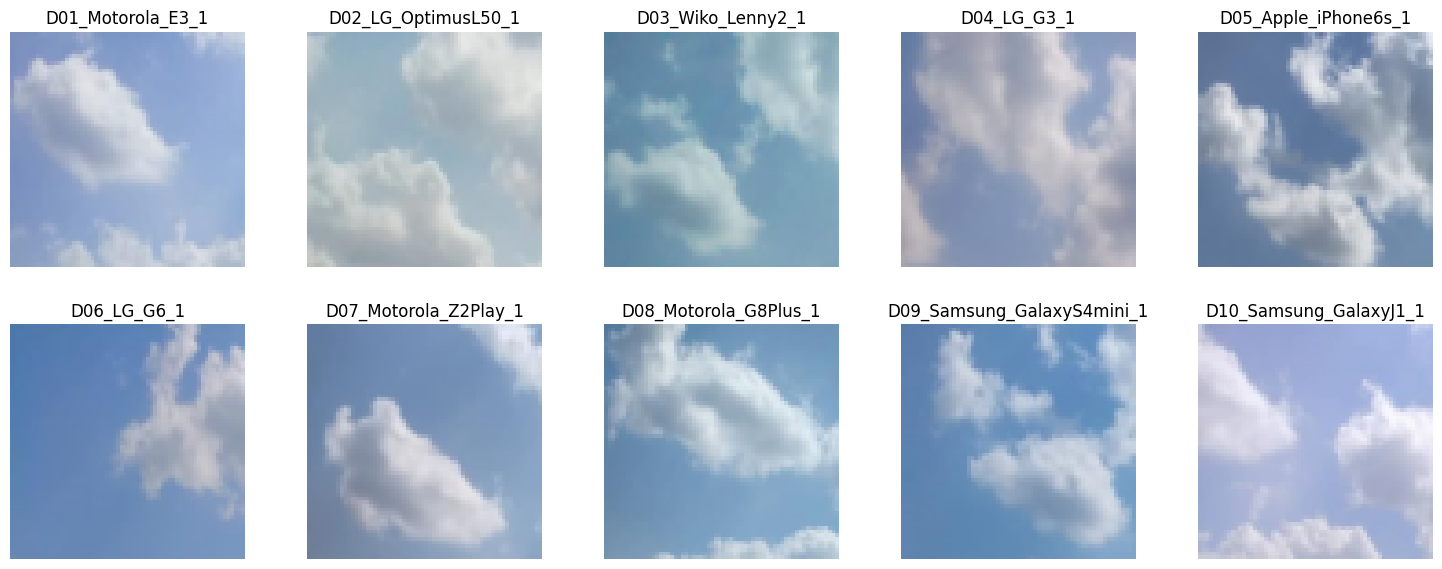

In [58]:
def print_first_patch_of_each_class(patch_loader):
    """Prints the first patch of each class with its label as the title in a grid.
    
    Args:
        patch_loader (torch.utils.data.DataLoader): The DataLoader containing patches and labels.
    """
    
    # Get the mapping from class index to class name
    class_to_idx = patch_loader.dataset.dataset.class_to_idx
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    
    # Dictionary to store the first patch of each class
    first_patches = {}
    
    for patches, labels in patch_loader:
        for patch, label in zip(patches, labels):
            label = label.item()  # Convert tensor to integer
            
            if label not in first_patches:
                first_patches[label] = patch
                # Stop once we have one patch for each class
                if len(first_patches) == len(class_to_idx):
                    break
    
    # Create a grid to display the patches
    num_classes = len(first_patches)
    rows, cols = (num_classes // 5) + (1 if num_classes % 5 > 0 else 0), min(5, num_classes)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    
    fig.tight_layout()
    
    row, col = 0, 0
    for label, patch in first_patches.items():
        axes[row, col].imshow(patch.permute(1, 2, 0))  # Assuming CHW format
        axes[row, col].set_title(idx_to_class[label])
        axes[row, col].axis('off')
        col += 1
        if col == cols:
            row += 1
            col = 0
    
    plt.show()

In [ ]:
print_first_patch_of_each_class(patch_loader_with_labels)

In [14]:
# dataloader dictionary
dataloader_dictionary=dataloader.dataset.class_to_idx
dataloader_dictionary

{'D01_Motorola_E3_1': 0,
 'D02_LG_OptimusL50_1': 1,
 'D03_Wiko_Lenny2_1': 2,
 'D04_LG_G3_1': 3,
 'D05_Apple_iPhone6s_1': 4,
 'D06_LG_G6_1': 5,
 'D07_Motorola_Z2Play_1': 6,
 'D08_Motorola_G8Plus_1': 7,
 'D09_Samsung_GalaxyS4mini_1': 8,
 'D10_Samsung_GalaxyJ1_1': 9}

In [15]:
# Define the PDN (Patch Discriminator Network)
class PDN(nn.Module):
    def __init__(self):
        super(PDN, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [16]:
# Define the Feature Extractor using ResNet-18
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        resnet = models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        
    def forward(self, x):
        return self.features(x).squeeze()

In [17]:
# Initialize models
feature_extractor = FeatureExtractor()
PDN_model = PDN()

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
attack = torchattacks.PGD(PDN_model, eps=1e-3, alpha=1/255, steps=10, random_start=True)

In [45]:
def train_feature_extractor_and_pdn(feature_extractor, pdn_model, dataloader, patch_loader, attack,device):
    feature_extractor.to(device)
    pdn_model.to(device)
    
    # Optimizers and loss functions
    feature_optimizer = optim.Adam(feature_extractor.parameters(), lr=0.001)
    pdn_optimizer = optim.Adam(pdn_model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ExponentialLR(feature_optimizer, gamma=0.97)
    # loss_fn = nn.KLDivLoss(reduction='batchmean')
    loss_fn = nn.MSELoss()

    # Training feature extractor
    # for epoch in tqdm(range(20)):
    #     feature_extractor.train()
    #     total_loss = 0.0
        
    #     for images in dataloader:
    #         images = images[0].to(device)
    #         features = feature_extractor(images)
            
    #         # Forward pass through PDN model
    #         reconstructed_images = pdn_model(images)
            
    #         # Compute loss
    #         # print(f"{reconstructed_images.shape}===={images.shape}")
    #         loss = loss_fn(reconstructed_images, images)
    #         total_loss += loss.item()
            
    #         # Backpropagation
    #         feature_optimizer.zero_grad()
    #         loss.backward()
    #         feature_optimizer.step()
        
    #     scheduler.step()
    #     print(f"Feature Extractor Epoch [{epoch + 1}/20], Loss: {total_loss / len(dataloader):.4f}")

    # Training PDN model
    for epoch in tqdm(range(10)):
        pdn_model.train()
        total_loss = 0.0
        
        for patches, labels in patch_loader:
            patches = patches.to(device)
            labels=labels.to(device)
            
            # print(f"{patches.shape}\n===={patches.argmax()}\n====={labels.shape}\n===={labels}\n===={labels.item()}")
            
            # Generate adversarial examples
            # adv_patches = attack(patches, labels=torch.zeros(patches.size(0), dtype=torch.long).to(device))
            adv_patches = attack(patches, labels)
            
            # Forward pass through PDN model
            reconstructed_patches = pdn_model(patches)
            adv_reconstructed_patches = pdn_model(adv_patches)
            
            # Compute loss on clean and adversarial examples
            loss = (loss_fn(reconstructed_patches, patches) + loss_fn(adv_reconstructed_patches, adv_patches)) / 2
            total_loss += loss.item()
            
            # Backpropagation
            pdn_optimizer.zero_grad()
            loss.backward()
            pdn_optimizer.step()
        
        print(f"PDN Model Epoch [{epoch + 1}/10], Loss: {total_loss / len(patch_loader):.4f}")

In [53]:
train_feature_extractor_and_pdn(feature_extractor, PDN_model,dataloader,patch_loader_with_labels, attack,device)

  0%|          | 0/10 [00:00<?, ?it/s]

tensor([0])


RuntimeError: only batches of spatial targets supported (3D tensors) but got targets of dimension: 1

In [ ]:
class Classifier(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super(Classifier, self).__init__()
        self.fc = nn.Linear(feature_dim, num_classes)
    
    def forward(self, x):
        return self.fc(x)

# Initialize the classifier
classifier = Classifier(feature_dim=512, num_classes=2)  # Assuming 2 classes


In [ ]:
# Function for majority voting
def major_voting(patches, feature_extractor, classifier, device):
    feature_extractor.eval()
    classifier.eval()
    with torch.no_grad():
        patch_labels = []
        for patch in patches:
            patch = patch.unsqueeze(0).to(device)
            features = feature_extractor(patch)
            logits = classifier(features)
            label = torch.argmax(logits, dim=0).item()
            patch_labels.append(label)
        
        # Aggregate results using majority voting
        most_common_label, _ = Counter(patch_labels).most_common(1)[0]
        return most_common_label

In [ ]:


# Function to evaluate model
def evaluate_model(patches_per_image, feature_extractor, classifier, device, true_labels):
    image_level_labels = []
    for patches in patches_per_image:
        predicted_label = major_voting(patches, feature_extractor, classifier, device)
        image_level_labels.append(predicted_label)
    
    # Evaluate accuracy
    accuracy = np.mean([pred == true_label for pred, true_label in zip(image_level_labels, true_labels)])
    print(f"Image Level Accuracy: {accuracy:.4f}")
    return accuracy



In [ ]:
# Extract patches and true labels
patches_per_image = []
true_labels = []

for images, labels in dataloader:
    images = images.squeeze(0)  # Remove batch dimension
    patches = extract_patches(images)
    patches_per_image.append(patches)
    true_labels.append(labels.item())



In [ ]:
# Evaluate model
accuracy = evaluate_model(patches_per_image, feature_extractor, classifier, device, true_labels)
print(f"Model accuracy on dataset: {accuracy:.4f}")

Image Level Accuracy: 0.1000
Model accuracy on dataset: 0.1000
